# **Customer Segmentation Using RFM**

## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

# Get the Data

In [ ]:
#load the dataset
retail_df = pd.read_csv('/content/drive/MyDrive/Portofolio/e-commerce.csv',encoding="ISO-8859-1", dtype={'CustomerID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
print(retail_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB
None


# Prepare the Data


As customer clusters may vary by geography, I’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [ ]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [ ]:
#remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [ ]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [ ]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(176137, 8)

In [ ]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  8789
Number of products bought:  3294
Number of customers: 2864
Percentage of customers NA:  0.0 %


# RFM Analysis

**RFM** (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. 
RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

## Recency

To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [ ]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

'9/9/2011 9:52'

The last date we have is 2011-12-09 so we will use it as reference.

In [ ]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [ ]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = pd.DatetimeIndex(retail_uk['InvoiceDate']).date

In [ ]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [ ]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12747,2011-08-22
1,12748,2011-09-30
2,12749,2011-08-01
3,12820,2011-09-26
4,12821,2011-05-09


In [ ]:

#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [ ]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12747,2011-08-22,109
1,12748,2011-09-30,70
2,12749,2011-08-01,130
3,12820,2011-09-26,74
4,12821,2011-05-09,214


In [ ]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

## Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check **how many invoices are registered by the same customer**.

In [ ]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747,5
1,12748,96
2,12749,3
3,12820,1
4,12821,1


## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [ ]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [ ]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747,191.85
1,12748,1054.43
2,12749,67.00
3,12820,15.00
4,12821,19.92


## Create RFM Table

In [ ]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12747,109,5
1,12748,70,96
2,12749,130,3
3,12820,74,1
4,12821,214,1


In [ ]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,109,5,191.85
12748,70,96,1054.43
12749,130,3,67.00
12820,74,1,15.00
12821,214,1,19.92


## RFM Table Correctness verification

In [ ]:
retail_uk[retail_uk['CustomerID']=='12820']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,9/26/2011 11:49,3.75,12820,United Kingdom,2011-09-26,15.0


In [ ]:
(now - dt.date(2011,9,26)).days == 74

True

## Customer segments with RFM Model

The simplest way to create customers segments from RFM Model is to use ** Tertiles**. We assign a score from 1 to 3 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

### RFM Tertiles

In [ ]:
tertiles = rfm_df.quantile(q=[0.33,0.66])
tertiles = rfm_df.quantile(q=[0.33,0.66])

In [ ]:
tertiles.to_dict()

{'Recency': {0.33: 92.0, 0.66: 156.0},
 'Frequency': {0.33: 1.0, 0.66: 3.0},
 'Monetary': {0.33: 19.9, 0.66: 62.400000000000006}}

### Creation of RFM Segments

Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = tertiles dict)
def RScore(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = tertiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3

In [ ]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Tertile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',tertiles,))
rfm_segmentation['F_Tertile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',tertiles,))
rfm_segmentation['M_Tertile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',tertiles,))

In [ ]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Tertile.map(str) \
                            + rfm_segmentation.F_Tertile.map(str) \
                            + rfm_segmentation.M_Tertile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Tertile,F_Tertile,M_Tertile,RFM_Score
CustomerID,,,,,,,
12747,109,5,191.85,2,3,3,233
12748,70,96,1054.43,3,3,3,333
12749,130,3,67.00,2,2,3,223
12820,74,1,15.00,3,1,1,311
12821,214,1,19.92,1,1,2,112


In [ ]:
import requests
from io import StringIO

In [ ]:
segment_name = {'112':'ABOUT TO SLEEP',
                '113':'ABOUT TO SLEEP', 
                '121':'ABOUT TO SLEEP',

                '122':'ABOUT TO SLEEP',
                '131':'ABOUT TO SLEEP', 
                '211':'ABOUT TO SLEEP',

                '212':'ABOUT TO SLEEP',
                '221':'ABOUT TO SLEEP', 

                '311':'RECENT CUSTOMER',
                '312':'RECENT CUSTOMER', 
                '313':'RECENT CUSTOMER',

                '123':'CANNOT LOOSE THEM',
                '132':'CANNOT LOOSE THEM', 
                '133':'CANNOT LOOSE THEM',

                '333':'CHAMPION',
                '111':'LOST CUSTOMER',

                '233':'LOYAL',
                '323':'LOYAL', 
                '332':'LOYAL',

                '223':'POTENTIAL LOYALIST',
                '223':'POTENTIAL LOYALIST', 
                '322':'POTENTIAL LOYALIST',
                '331':'POTENTIAL LOYALIST',

                '213':'AVERAGE',
                '222':'AVERAGE', 
                '231':'AVERAGE',
                '321':'AVERAGE'}

In [ ]:
rfm_segmentation["segment_name"] = rfm_segmentation["RFM_Score"].map(segment_name)

In [ ]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Tertile,F_Tertile,M_Tertile,RFM_Score,segment_name
CustomerID,,,,,,,,
12747,109,5,191.85,2,3,3,233,LOYAL
12748,70,96,1054.43,3,3,3,333,CHAMPION
12749,130,3,67.00,2,2,3,223,POTENTIAL LOYALIST
12820,74,1,15.00,3,1,1,311,RECENT CUSTOMER
12821,214,1,19.92,1,1,2,112,ABOUT TO SLEEP


In [ ]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Tertile,F_Tertile,M_Tertile,RFM_Score,segment_name
CustomerID,,,,,,,,
12747,109,5,191.85,2,3,3,233,LOYAL
12748,70,96,1054.43,3,3,3,333,CHAMPION
12749,130,3,67.00,2,2,3,223,POTENTIAL LOYALIST
12820,74,1,15.00,3,1,1,311,RECENT CUSTOMER
12821,214,1,19.92,1,1,2,112,ABOUT TO SLEEP


In [ ]:
rfm_segmentation[['segment_name']].value_counts()

segment_name      
ABOUT TO SLEEP        716
LOST CUSTOMER         460
CHAMPION              352
LOYAL                 334
AVERAGE               306
POTENTIAL LOYALIST    283
RECENT CUSTOMER       260
CANNOT LOOSE THEM      93
dtype: int64

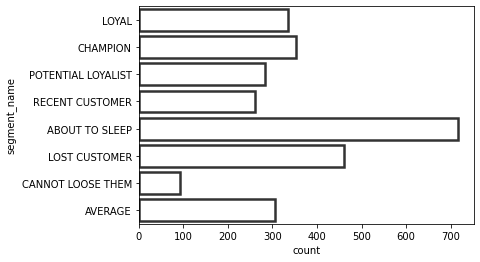

In [ ]:
ax = sns.countplot(y="segment_name", data=rfm_segmentation, linewidth=2.5, facecolor=(1, 1, 1, 0), edgecolor=".2")

In [ ]:
rfm_segmentation.groupby('segment_name')['Monetary'].sum()

segment_name
ABOUT TO SLEEP         35825.10
AVERAGE                16263.10
CANNOT LOOSE THEM      58931.01
CHAMPION              254017.41
LOST CUSTOMER           5223.79
LOYAL                  84726.89
POTENTIAL LOYALIST     29871.22
RECENT CUSTOMER        10362.94
Name: Monetary, dtype: float64

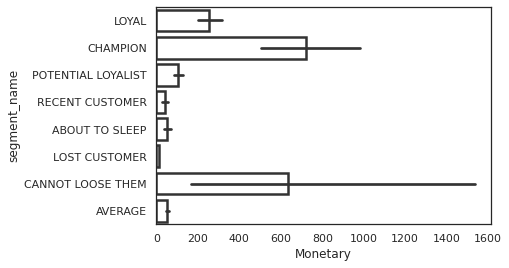

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Monetary", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
            
plt.show()

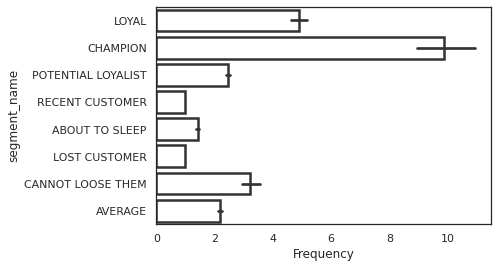

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Frequency", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
            
plt.show()

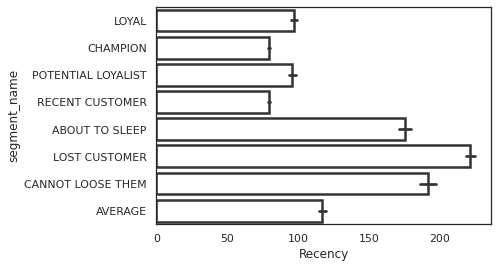

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Recency", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
            
plt.show()